### Mount google drive to the colab

In [1]:
# comment this line if using local machine
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## Importing necessary libraries

In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt

import pickle

# sklearn libraries
from sklearn.model_selection import train_test_split

# tensorflow/keras libraries
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as keras

## Data preparation and preprocessing 

In [0]:
X_train = np.load("drive/My Drive/Project/Train/x_mag_500batch1.npy", mmap_mode='r')
y_train = np.load("drive/My Drive/Project/Train/y_mag_500batch1.npy", mmap_mode='r')

X_train = np.vstack((X_train,np.load("drive/My Drive/Project/Train/x_mag_500batch1_drone_full_noise.npy", mmap_mode='r')))
y_train = np.vstack((y_train,np.load("drive/My Drive/Project/Train/y_mag_500batch1.npy", mmap_mode='r')))

#### Creating train test split

In [0]:
y = np.zeros((30000,1))
y[15000:30000] = 1
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, random_state=42, stratify=y)

## Denoising model creation (RESNET)

In [0]:
input_size = (8,129,17)
inputs = Input(input_size)
conv1 = Conv2D(32, 7, padding = 'same', kernel_initializer = 'he_normal', data_format='channels_first')(inputs)
conv1 = BatchNormalization(axis=1)(conv1)
conv1 = Activation('relu')(conv1)

conv2 = Conv2D(64, 5, padding = 'valid', kernel_initializer = 'he_normal', data_format='channels_first')(conv1)
conv2 = BatchNormalization(axis=1)(conv2)
conv2 = Activation('relu')(conv2)
conv3 = Conv2D(128, 5, padding = 'valid', kernel_initializer = 'he_normal', data_format='channels_first')(conv2)
conv3 = BatchNormalization(axis=1)(conv3)

conv4 = Conv2D(128, 9, padding = 'valid', kernel_initializer = 'he_normal', data_format='channels_first')(conv1)
conv4 = BatchNormalization(axis=1)(conv4)

merge_conv34 = concatenate([conv3,conv4], axis=1)
merge_conv34 = Activation('relu')(merge_conv34)

conv5 = Conv2D(256, 3, padding = 'valid', kernel_initializer = 'he_normal', data_format='channels_first')(merge_conv34)
conv5 = BatchNormalization(axis=1)(conv5)
conv5 = Activation('relu')(conv5)
conv6 = Conv2D(512, 3, padding = 'valid', kernel_initializer = 'he_normal', data_format='channels_first')(conv5)
conv6 = BatchNormalization(axis=1)(conv6)

conv7 = Conv2D(512, 5, padding = 'valid', kernel_initializer = 'he_normal', data_format='channels_first')(merge_conv34)
conv7 = BatchNormalization(axis=1)(conv7)

merge_conv67 = concatenate([conv6,conv7], axis=1)
merge_conv67 = Activation('relu')(merge_conv67)

#conv8 = Conv2D(1024, 3, padding = 'same', kernel_initializer = 'he_normal', data_format='channels_first')(merge_conv67)

conv8 = Conv2DTranspose(512, 3, padding = 'valid', kernel_initializer = 'he_normal', data_format='channels_first')(merge_conv67)
conv8 = BatchNormalization(axis=1)(conv8)
conv8 = Activation('relu')(conv8)
conv9 = Conv2DTranspose(256, 3, padding = 'valid', kernel_initializer = 'he_normal', data_format='channels_first')(conv8)
conv9 = BatchNormalization(axis=1)(conv9)

conv10 = Conv2DTranspose(256, 5, padding = 'valid', kernel_initializer = 'he_normal', data_format='channels_first')(merge_conv67)
conv10 = BatchNormalization(axis=1)(conv10)

merge_conv910 = concatenate([conv9,conv10], axis=1)
merge_conv910 = Activation('relu')(merge_conv910)

conv8 = Conv2DTranspose(128, 3, padding = 'valid', kernel_initializer = 'he_normal', data_format='channels_first')(merge_conv67)
conv8 = BatchNormalization(axis=1)(conv8)
conv8 = Activation('relu')(conv8)
conv9 = Conv2DTranspose(256, 3, padding = 'valid', kernel_initializer = 'he_normal', data_format='channels_first')(conv8)
conv9 = BatchNormalization(axis=1)(conv9)

conv10 = Conv2DTranspose(256, 5, padding = 'valid', kernel_initializer = 'he_normal', data_format='channels_first')(merge_conv67)
conv10 = BatchNormalization(axis=1)(conv10)

merge_conv910 = concatenate([conv9,conv10], axis=1)
merge_conv910 = Activation('relu')(merge_conv910)

conv11 = Conv2DTranspose(128, 5, padding = 'valid', kernel_initializer = 'he_normal', data_format='channels_first')(merge_conv910)
conv11 = BatchNormalization(axis=1)(conv11)
conv11 = Activation('relu')(conv11)
conv12 = Conv2DTranspose(64, 5, padding = 'valid', kernel_initializer = 'he_normal', data_format='channels_first')(conv11)
conv12 = BatchNormalization(axis=1)(conv12)

conv13 = Conv2DTranspose(64, 9, padding = 'valid', kernel_initializer = 'he_normal', data_format='channels_first')(merge_conv910)
conv13 = BatchNormalization(axis=1)(conv13)

merge_conv1213 = concatenate([conv12,conv13], axis=1)
merge_conv1213 = Activation('relu')(merge_conv1213)

conv14 = Conv2D(1, 3, padding = 'same', kernel_initializer = 'he_normal', data_format='channels_first')(merge_conv1213)
conv14 = BatchNormalization(axis=1)(conv14)
conv14 = Activation('relu')(conv14)

model = Model(inputs = inputs, outputs = conv14)

model.compile(optimizer = Adam(lr = 0.01), loss = 'mean_squared_error', metrics = ['accuracy'])

model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 8, 129, 17)] 0                                            
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 32, 129, 17)  12576       input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_34 (BatchNo (None, 32, 129, 17)  128         conv2d_16[0][0]                  
__________________________________________________________________________________________________
activation_24 (Activation)      (None, 32, 129, 17)  0           batch_normalization_34[0][0]     
______________________________________________________________________________________________

#### Setup callback method for early stopping

In [0]:
early_stopping_monitor = EarlyStopping(monitor='val_loss', 
                                                        patience=5, 
                                                        verbose=2,
                                                        restore_best_weights=True)


## Model Compilation and training

In [0]:
model.compile(loss=mean_squared_error,
              optimizer=Adam(lr=0.01, beta_1=0.9, beta_2=0.999),
              metrics=['accuracy'])
model.fit(X_train,y_train,
                    batch_size=64,
                    epochs=100,
                    validation_split = 0.2,
                    shuffle = True,
                    callbacks=[early_stopping_monitor]
                   )

Train on 19200 samples, validate on 4800 samples
Epoch 1/100
19200/19200 [==============================] - 402s 21ms/sample - loss: 30965.8548 - acc: 0.1158 - val_loss: 29367.6846 - val_acc: 0.0695
Epoch 2/100
19200/19200 [==============================] - 385s 20ms/sample - loss: 29778.2325 - acc: 0.1318 - val_loss: 28737.0872 - val_acc: 0.1350
Epoch 3/100
19200/19200 [==============================] - 385s 20ms/sample - loss: 28683.4791 - acc: 0.1394 - val_loss: 28169.2293 - val_acc: 0.1390
Epoch 4/100
19200/19200 [==============================] - 385s 20ms/sample - loss: 27635.3731 - acc: 0.1450 - val_loss: 26769.2461 - val_acc: 0.1453
Epoch 5/100
19200/19200 [==============================] - 388s 20ms/sample - loss: 26626.2441 - acc: 0.1523 - val_loss: 26345.8899 - val_acc: 0.1381
Epoch 6/100
19200/19200 [==============================] - 385s 20ms/sample - loss: 25652.0367 - acc: 0.1581 - val_loss: 24599.2229 - val_acc: 0.1612
Epoch 7/100
19200/19200 [==========================

## Saving model and its training history

In [0]:
model.save("drive/My Drive/Project/Models/Denoise/RESNET/resnet_param_18,185,957_val_loss_6789.5098_val_acc_0.1969_tf.keras.h5")
pickle.dump(model.history.history, open('drive/My Drive/Project/Models/Denoise/RESNET/history_resnet_param_18,185,957_val_loss_6789.5098_val_acc_0.1969_tf.keras.pkl', 'wb'))

## Loading trained model for prediction and analysis

In [0]:
model = load_model("drive/My Drive/Project/Models/Denoise/RESNET/resnet_param_18,185,957_val_loss_6789.5098_val_acc_0.1969_tf.keras.h5")

W0804 19:41:25.906657 139737706219392 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0804 19:41:25.908210 139737706219392 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0804 19:41:25.911428 139737706219392 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Ones.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprec

#### Model architecture plot

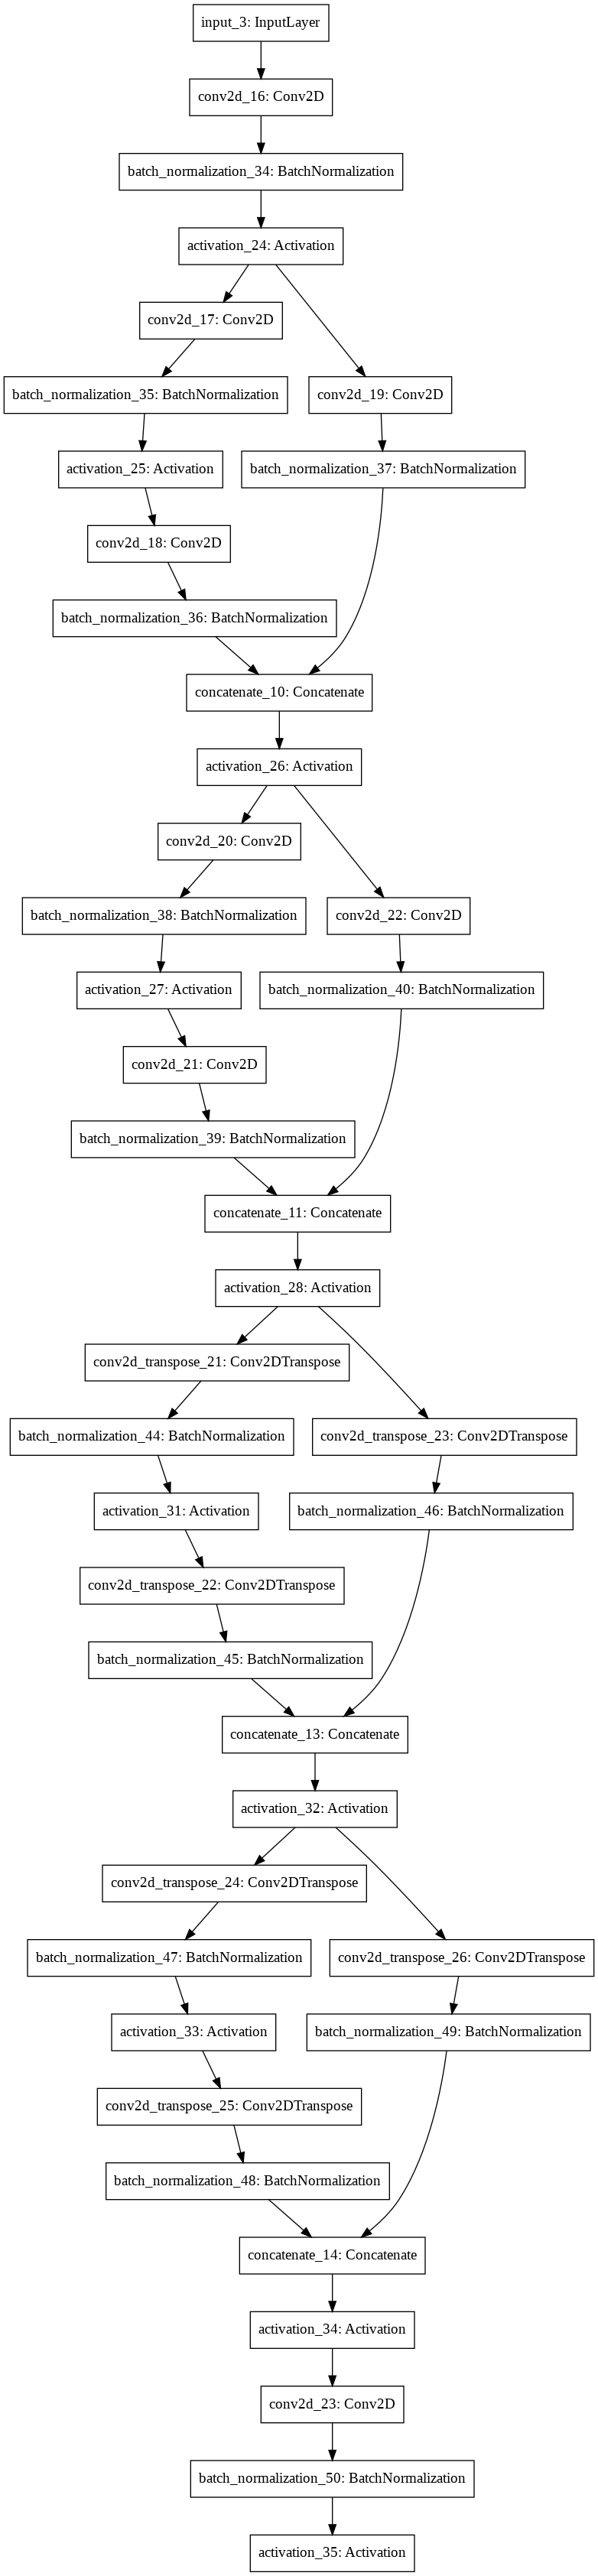

In [0]:
from IPython.display import SVG
from tensorflow.keras.utils import plot_model
plot_model(model, to_file="drive/My Drive/Project/Models/Denoise/RESNET/architecture_resnet_model.png")

## Model evalution and analysis

In [0]:
val_loss, val_acc = model.evaluate(X_test, y_test)

6000/6000 [==============================] - 36s 6ms/sample - loss: 7009.7447 - acc: 0.1970


### Accuracy Score

In [0]:
print(f'Validation loss of Model : {val_loss}')
print(f'Validation accuracy of Model : {val_acc}')

Validation loss of Model : [29367.684583333332, 28737.087239583332, 28169.229270833333, 26769.246080729168, 26345.8898828125, 24599.222916666666, 24571.452890625, 24062.115455729167, 22461.07703125, 22120.374010416668, 21048.6082421875, 20518.818255208334, 20620.487135416668, 18636.1137109375, 19240.290625, 17121.064544270834, 17373.906666666666, 17246.832395833335, 16411.844244791668, 15645.733333333334, 15126.342903645833, 15495.339192708334, 14862.54328125, 14134.036302083334, 13642.66666015625, 14002.091953125, 13127.207591145834, 12830.325384114583, 12184.87619140625, 12198.182239583333, 11405.976634114584, 11091.451490885416, 11405.646790364583, 10755.69236328125, 10375.014765625, 10406.103001302083, 10735.588001302083, 10170.99734375, 9580.82671875, 9134.98677734375, 8787.2254296875, 8969.695989583333, 8857.974713541667, 8603.078658854167, 8470.86091796875, 8592.3002734375, 8189.743932291667, 7831.11072265625, 7858.984072265625, 7642.319921875, 7524.285608723958, 7587.136484375,

### Model training vs validation loss plot

In [0]:
history = pickle.load(open('drive/My Drive/Project/Models/Denoise/RESNET/history_resnet_param_18,185,957_val_loss_6789.5098_val_acc_0.1969_tf.keras.pkl', 'rb'))

In [0]:
train_loss = history['loss']
train_acc = history['acc']
val_loss = history['val_loss']
val_acc = history['val_acc']

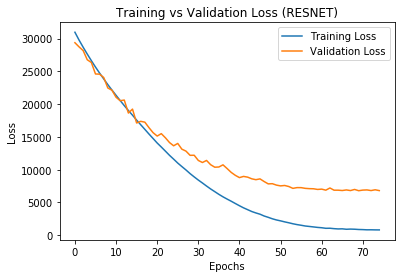

In [5]:
plt.plot(train_loss, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss (RESNET)')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.savefig("drive/My Drive/Project/Models/Denoise/RESNET/loss_graph_resnet_model.png")
plt.show()